In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
labels_dict = {'wanita_mojaris': 'wanita mojaris',
 'pria_kurta': 'pria kurta',
 'blus': 'blus',
 'rok_dalam': 'rok',
 'lehenga': 'lehenga',
  'jaket_nehru': 'jaket nehru',
 'celana_dhoti': 'celana dhoti',
 'palazzo': 'palazzo',
 'sari': 'sari',
 'dupatta': 'dupatta',
 'pria_mojaris': 'pria mojaris',
 'sherwani': 'sherwani',
 'gaun': 'gaun',
 'legging_dan_salwar': 'legging dan salwar',
 'wanita_kurta': 'wanita kurta'}

labels = list(labels_dict.values())

In [ ]:
import os

MODEL_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/model/"
RESULT_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/result/"
DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/data/"
FASHION_DIR = os.path.join(DATA_DIR, "indo_fashion/")
FASHION_MINI_DIR = os.path.join(DATA_DIR, "indo_fashion_mini/")
BEST_PATH = os.path.join(MODEL_DIR, "CLIP_fashion_best3")

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, VisionTextDualEncoderModel, AutoTokenizer, BertTokenizer

model_base = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p2")

model_best = VisionTextDualEncoderModel.from_pretrained(BEST_PATH, from_flax=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_flax_pytorch_utils.py:460: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect it

In [ ]:
import pandas as pd

test_df = pd.read_csv(os.path.join(FASHION_MINI_DIR,"test.csv"))

In [ ]:
print("Test size:", len(test_df))

Test size: 4500


In [ ]:
test_df = test_df[["image_path", "ID_product_title", "ID_class_label"]]
test_df = test_df.dropna()

In [ ]:
test_df["ID_class_label"].value_counts()

lehenga               300
rok_dalam             300
wanita_mojaris        300
blus                  300
pria_mojaris          300
legging_dan_salwar    300
sari                  300
palazzo               300
gaun                  300
celana_dhoti          300
sherwani              300
jaket_nehru           300
dupatta               300
pria_kurta            300
wanita_kurta          300
Name: ID_class_label, dtype: int64

In [ ]:
image_path_list = test_df["image_path"].apply(lambda x: os.path.join(FASHION_MINI_DIR, x)).tolist()
caption_list = test_df["ID_product_title"].tolist()
label_list = test_df["ID_class_label"].apply(lambda x: labels_dict[x]).tolist()

## Embedding

### Compute Embedding

In [ ]:
import torch

MAX_LEN_TEXT = 512

class ImageTitleDataset():
    def __init__(self, list_image_path, list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title = processor.tokenizer(list_txt, truncation=True, padding=True, max_length=MAX_LEN_TEXT, return_tensors="pt")
        self.title = dict(self.title)
        for key, value in self.title.items():
          self.title[key] = torch.as_tensor(self.title[key])
        self.newsize = (224, 224)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = Image.open(self.image_path[idx])
        image = image.resize(self.newsize)
        # shape: torch.Size([3, 224, 224])
        # image = transform(image)
        # shape: torch.Size([1, 3, 224, 224]) -> torch.Size([3, 224, 224])
        image = processor.image_processor(image, return_tensors="pt").pixel_values.squeeze(0)
        # assert len(image.shape) == 3 and tuple(image.shape[1:]) == self.newsize
        text = self.title["input_ids"][idx]
        attention_mask = self.title["attention_mask"][idx]

        return image, text, attention_mask

In [ ]:
import numpy as np

def embed_texts(input_ids, attention_mask, model):
    with torch.no_grad():
        embeddings = model.get_text_features(
            input_ids=input_ids, attention_mask=attention_mask
        )
    return embeddings

def embed_images(pixel_values, model):
    with torch.no_grad():
        embeddings = model.get_image_features(pixel_values=pixel_values)
    return embeddings

In [ ]:
from torch.utils.data import DataLoader

dataset = ImageTitleDataset(image_path_list, caption_list)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model_base.eval()
model_base.to(device)

# model_best.eval()
# model_best.to(device)

image_embeddings = []
for batch in tqdm(dataloader, total=len(dataloader)):
  images,_,_ = batch
  images= images.to(device)
  embeds = embed_images(images, model_base)
  # embeds = embed_images(images, model_best)
  image_embeddings.append(embeds)

image_embeddings = torch.cat(image_embeddings).cpu()

### Vectors and Smiliarities (PCA)

reference: https://colab.research.google.com/drive/1zObyENn4rZgHeHzzXvfUPIgZ9mvsh-Hv?usp=sharing#scrollTo=IdEMZzjRxus8

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

# def scatter_with_pca(texts, images):
def scatter_with_pca(texts, images, input_ids, attention_mask, pixel_values, model):
    if not isinstance(images, list):
        images = [images]

    # text_embeds = embed_texts(texts, processor, model)
    # image_embed = embed_images(images, processor, model)
    text_embeds = embed_texts(input_ids, attention_mask, model)
    image_embed = embed_images(pixel_values, model)

    pca = PCA(n_components=2)
    X = torch.cat([text_embeds, image_embed], axis=0)
    X_2d = pca.fit_transform(X)

    X_texts = X_2d[:len(texts), :]
    X_images = X_2d[len(texts):, :]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X_texts[:, 0], X_texts[:, 1], c="darkorange", label="Text")

    for idx, image in enumerate(images):
        imagebox = OffsetImage(image, zoom=0.1)
        ab = AnnotationBbox(imagebox, (X_images[idx, 0] - .6, X_images[idx, 1] - .5))
        ax.add_artist(ab)

    ax.scatter(X_images[:, 0], X_images[:, 1], c="royalblue", label="Image")

    plt.legend()

    for index, word in enumerate(texts):
        # annotate
        plt.annotate(word, xy=(X_texts[index, 0], X_texts[index, 1]))

In [ ]:
print(labels)

['wanita mojaris', 'pria kurta', 'blus', 'rok', 'lehenga', 'jaket nehru', 'celana dhoti', 'palazzo', 'sari', 'dupatta', 'pria mojaris', 'sherwani', 'gaun', 'legging dan salwar', 'wanita kurta']


In [ ]:
texts = labels

dataset = ImageTitleDataset(image_path_list, texts)
dataloader = DataLoader(dataset, batch_size=15, shuffle=False)

for batch in dataloader:
  pixel_values, input_ids, attention_mask = batch
  break

In [ ]:
text_embeds = embed_texts(input_ids, attention_mask, model_best)
image_embed = embed_images(pixel_values, model_best)

In [ ]:
import torch.nn.functional as F

similarities = F.cosine_similarity(image_embed, text_embeds)
for text, s in zip(texts, similarities):
    print(text, ":", s)

wanita mojaris : tensor(-0.0086)
pria kurta : tensor(-0.2246)
blus : tensor(-0.0874)
rok : tensor(-0.0978)
lehenga : tensor(-0.6108)
jaket nehru : tensor(-0.1519)
celana dhoti : tensor(0.9289)
palazzo : tensor(-0.1088)
sari : tensor(-0.1003)
dupatta : tensor(0.5047)
pria mojaris : tensor(-0.0390)
sherwani : tensor(-0.1121)
gaun : tensor(-0.0158)
legging dan salwar : tensor(-0.0105)
wanita kurta : tensor(0.5960)


Also, since we have vectors, we can try to do some sort of visualization. Using the classical PCA, we can extract a two-dimensional representation of vectors and scatter plot them.

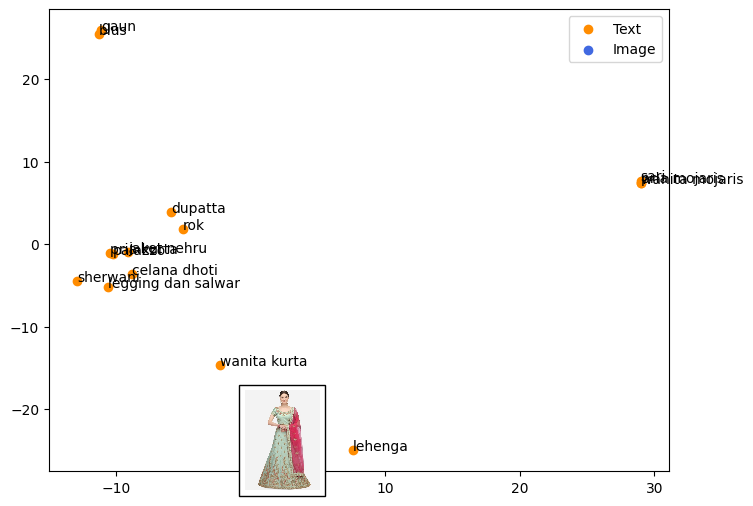

In [ ]:
# images = [Image.open(image_path_list[idx]) for idx in range(8)]
img_idx = 0
images = [Image.open(image_path_list[img_idx])]
scatter_with_pca(texts, images, input_ids, attention_mask, pixel_values[img_idx].unsqueeze(0), model_best)

## Zero Shot Classification

In [ ]:
from tqdm import tqdm
from PIL import Image
from PIL.JpegImagePlugin import JpegImageFile
from typing import List

In [ ]:
def get_predictions(labels: List[str], image: JpegImageFile, processor, model, verbose=False):
  # image: class PIL.JpegImagePlugin.JpegImageFile
  # text is the labels
  inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

  if verbose:
    for idx, prob in sorted(enumerate(*probs), key=lambda x: x[1], reverse=True):
      print(labels[idx], prob)

  return probs

# def get_highest_prediction(labels, probs):
#   idx, prob = sorted(enumerate(*probs), key=lambda x: x[1], reverse=True)[0]
#   return labels[idx]

def get_highest_prediction(labels, probs, k=1):
    sorted_probs = sorted(enumerate(probs), key=lambda x: x[1], reverse=True)[:k]
    top_predictions = [(labels[idx], prob) for idx, prob in sorted_probs]
    return top_predictions

def load_image(path="", url=""):
  if path:
    return Image.open(path)
  elif url:
    return Image.open(requests.get(url, stream=True).raw)
  return None

In [ ]:
base_preds = []
best_preds = []
for img_path in tqdm(image_path_list):
  img = load_image(path=img_path)
  probs = get_predictions(labels, img, processor, model_base, verbose=False)
  base_preds.append(get_highest_prediction(labels, probs, k=5))

  probs = get_predictions(labels, img, processor, model_best, verbose=False)
  best_preds.append(get_highest_prediction(labels, probs, k=5))

  0%|          | 16/4500 [02:15<14:22:32, 11.54s/it]

In [ ]:
# import json

# with open(os.path.join(RESULT_DIR, "classification_base.json"), "w") as f:
#   result = {
#       "gold": label_list,
#       "predictions": base_preds,
#   }
#   json.dump(result, f, indent=4)

# with open(os.path.join(RESULT_DIR, "classification_best.json"), "w") as f:
#   result = {
#       "gold": label_list,
#       "predictions": best_preds,
#   }
#   json.dump(result, f, indent=4)

In [ ]:
# import json

# with open(os.path.join(RESULT_DIR, "classification_base.json")) as f:
#   result_base = json.load(f)

# with open(os.path.join(RESULT_DIR, "classification_best.json")) as f:
#   result_best = json.load(f)

# label_list = result_base["gold"]
# base_preds = result_base["predictions"]
# best_preds = result_best["predictions"]

In [ ]:
from sklearn.metrics import accuracy_score

print(f"[Accuracy Score] Base ID CLIP Prediction: {accuracy_score(label_list, base_preds):.2%}")
print(f"[Accuracy Score] Finetune CLIP Prediction: {accuracy_score(label_list, best_preds):.2%}")

[Accuracy Score] Base ID CLIP Prediction: 16.53%
[Accuracy Score] Finetune CLIP Prediction: 27.49%


In [ ]:
from sklearn.metrics import f1_score

"""
Use macro F1-score when you want to evaluate the model's performance across all classes equally.
    A low macro F1-score implies that the model's precision and recall are poor for each individual class,
    indicating that it struggles to correctly classify instances across different classes.
Use micro F1-score when you want to evaluate the overall performance of the model across all classes as a single metric.
    A low micro F1-score suggests that the model's predictions and the ground truth labels do not align well overall,
    with a high number of false positives, false negatives, or misclassified instances across all classes.
Use weighted F1-score when you want to account for class imbalance and give more importance to classes with larger numbers of instances.
"""

# we are not using weighted because the data is balance
print(f"[F1 Score - Macro] Base ID CLIP Prediction: {f1_score(label_list, base_preds, average='macro'):.2%}")
print(f"[F1 Score - Macro] Finetune CLIP Prediction: {f1_score(label_list, best_preds, average='macro'):.2%}")

print(f"[F1 Score - Micro] Base ID CLIP Prediction: {f1_score(label_list, base_preds, average='micro'):.2%}")
print(f"[F1 Score - Micro] Finetune CLIP Prediction: {f1_score(label_list, best_preds, average='micro'):.2%}")

[F1 Score - Macro] Base ID CLIP Prediction: 11.89%
[F1 Score - Macro] Finetune CLIP Prediction: 25.52%
[F1 Score - Micro] Base ID CLIP Prediction: 16.53%
[F1 Score - Micro] Finetune CLIP Prediction: 27.49%


In [ ]:
from sklearn.metrics import recall_score

print(f"[Recall Score - Macro] Base ID CLIP Prediction: {recall_score(label_list, base_preds, average='macro'):.2%}")
print(f"[Recall Score - Macro] Finetune CLIP Prediction: {recall_score(label_list, best_preds, average='macro'):.2%}")

print(f"[Recall Score - Micro] Base ID CLIP Prediction: {recall_score(label_list, base_preds, average='micro'):.2%}")
print(f"[Recall Score - Micro] Finetune CLIP Prediction: {recall_score(label_list, best_preds, average='micro'):.2%}")

[Recall Score - Macro] Base ID CLIP Prediction: 16.53%
[Recall Score - Macro] Finetune CLIP Prediction: 27.49%
[Recall Score - Micro] Base ID CLIP Prediction: 16.53%
[Recall Score - Micro] Finetune CLIP Prediction: 27.49%


In [ ]:
from sklearn.metrics import precision_score

print(f"[Precision Score - Macro] Base ID CLIP Prediction: {precision_score(label_list, base_preds, average='macro'):.2%}")
print(f"[Precision Score - Macro] Finetune CLIP Prediction: {precision_score(label_list, best_preds, average='macro'):.2%}")

print(f"[Precision Score - Micro] Base ID CLIP Prediction: {precision_score(label_list, base_preds, average='micro'):.2%}")
print(f"[Precision Score - Micro] Finetune CLIP Prediction: {precision_score(label_list, best_preds, average='micro'):.2%}")

[Precision Score - Macro] Base ID CLIP Prediction: 15.41%
[Precision Score - Macro] Finetune CLIP Prediction: 32.44%
[Precision Score - Micro] Base ID CLIP Prediction: 16.53%
[Precision Score - Micro] Finetune CLIP Prediction: 27.49%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


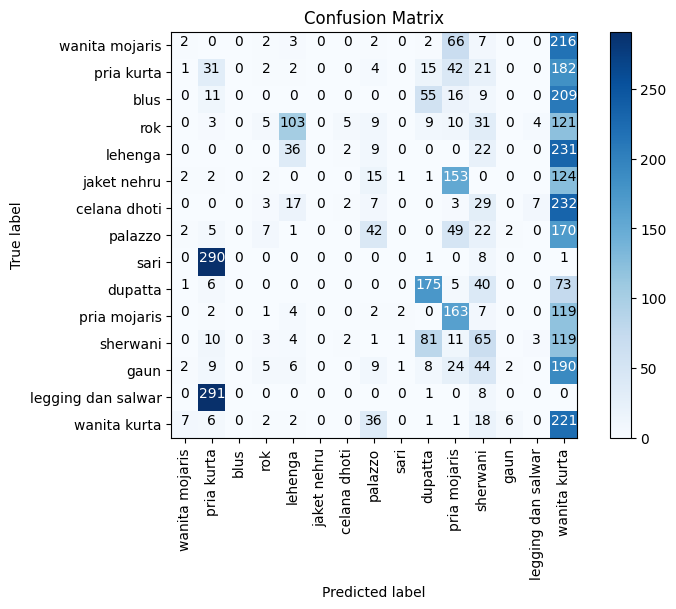

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

label_unique = list(set(label_list))
cm = confusion_matrix(label_list, base_preds, labels=label_unique)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)

# Add numerical values inside the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

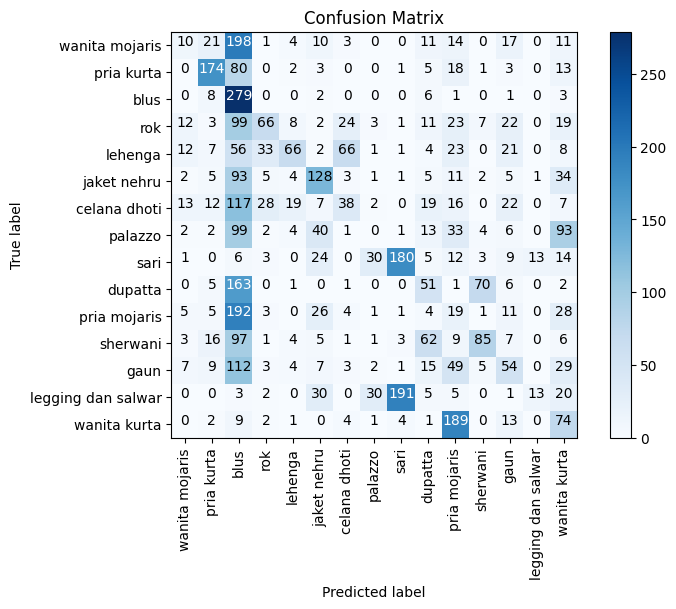

In [ ]:
cm = confusion_matrix(label_list, best_preds, labels=label_unique)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)

# Add numerical values inside the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Reducing the Class

In [ ]:
# reduced_labels_dict = {
#     'pakaian tradisional india': ['lehenga', 'sari', 'dupatta'],
#     'pakaian wanita': ['blus', 'gaun'],
#     'pakaian tradisional pria india': ['sherwani', 'jaket nehru'],
#     'mojaris': ['wanita mojaris', 'pria mojaris'],  # New category for both men's and women's mojaris
#     'kurta': ['wanita kurta', 'pria kurta'],
#     'bawahan': ['celana dhoti', 'legging dan salwar', 'rok'],  # Combined 'celana_dhoti' with bottoms
#     'palazzo': ['palazzo']
# }

# same but already flattened
reduced_labels_dict = {
    'lehenga': 'pakaian tradisional india',
    'sari': 'pakaian tradisional india',
    'dupatta': 'pakaian tradisional india',
    'blus': 'pakaian wanita',
    'gaun': 'pakaian wanita',
    'sherwani': 'pakaian tradisional pria india',
    'jaket nehru': 'pakaian tradisional pria india',
    'wanita mojaris': 'mojaris',
    'pria mojaris': 'mojaris',
    'wanita kurta': 'kurta',
    'pria kurta': 'kurta',
    'celana dhoti': 'bawahan',
    'legging dan salwar': 'bawahan',
    'rok': 'bawahan',
    'palazzo': 'palazzo'
}

reduced_labels = list(set(reduced_labels_dict.values()))

In [ ]:
len(reduced_labels), reduced_labels

(7,
 ['kurta',
  'pakaian tradisional pria india',
  'palazzo',
  'pakaian wanita',
  'mojaris',
  'pakaian tradisional india',
  'bawahan'])

In [ ]:
reduced_label_list = [reduced_labels_dict[label] if label in reduced_labels_dict else label for label in label_list]

In [ ]:
reduced_label_list[:10]

['pakaian tradisional india',
 'bawahan',
 'mojaris',
 'mojaris',
 'pakaian wanita',
 'mojaris',
 'bawahan',
 'pakaian tradisional india',
 'bawahan',
 'bawahan']

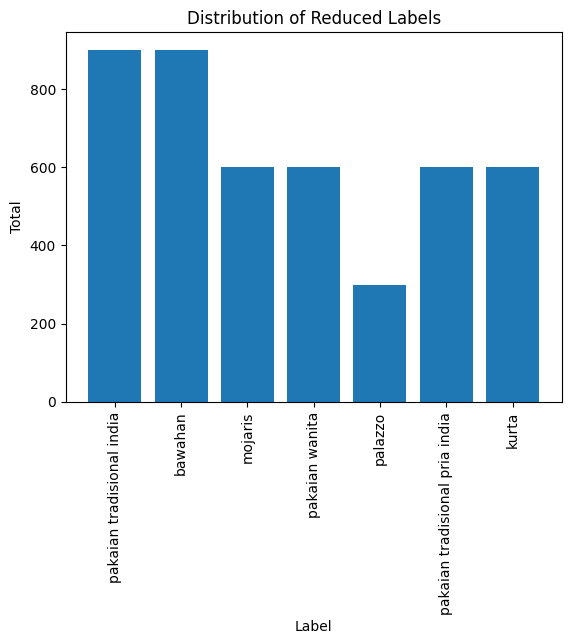

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in the list
counts = {}
for value in reduced_label_list:
    counts[value] = counts.get(value, 0) + 1

# Extract the unique values and their counts
values = list(counts.keys())
counts_values = list(counts.values())

# Plot the bar chart
plt.bar(values, counts_values)

# Rotate x-axis tick labels
plt.xticks(values, rotation=90)  # Adjust the rotation angle as needed

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Total')
plt.title('Distribution of Reduced Labels')

# Show the plot
plt.show()

In [ ]:
from tqdm import tqdm

red_base_preds = []
red_best_preds = []
for img_path in tqdm(image_path_list):
  img = load_image(path=img_path)
  probs = get_predictions(reduced_labels, img, processor, model_base, verbose=False)
  red_base_preds.append(get_highest_prediction(reduced_labels, probs, k=5))

  probs = get_predictions(reduced_labels, img, processor, model_best, verbose=False)
  red_best_preds.append(get_highest_prediction(reduced_labels, probs, k=5))

  5%|▍         | 204/4500 [06:02<5:24:11,  4.53s/it]

## Image Retriever

### Retrieval

In [ ]:
# use this func if needed only
import natsort
from typing import List

"""
# Suppose you have a list of filenames
all_imgs = ['image1.jpg', 'image10.jpg', 'image2.jpg', 'image11.jpg']

# Sort the list using natsorted
sorted_imgs = natsort.natsorted(all_imgs)

print(sorted_imgs)
# output: ['image1.jpg', 'image2.jpg', 'image10.jpg', 'image11.jpg']
"""
def sort_filenames_naturally(filenames: List[str]) -> List[str]:
  return natsort.natsorted(filenames)

In [ ]:
"""
# Suppose distances contains some numerical values
distances = np.array([0.3, 0.7, 0.5, 0.9, 0.2, 0.8])

# Let's say we want to select the indices of the top 3 elements in distances
n = 3

# Get the indices of the top n elements
idxs = distances.argsort()[-n:][::-1]

print(idxs)  # Output: [3 5 1]
"""
def get_indices_of_top_n_ranks(distances: List[float], n: int) -> List[int]:
  # sorted from [index rank_1, index rank_2, and so on]
  return distances.argsort()[-n:][::-1]

In [ ]:
import torch

base_image_embeds = torch.load(os.path.join(FASHION_MINI_DIR, "base_ID-fashion_15k_embeddings.pt"))
best_image_embeds = torch.load(os.path.join(FASHION_MINI_DIR, "finetune-fashion_15k_embeddings.pt"))

In [ ]:
MAX_LEN_TEXT = 512

In [ ]:
import numpy as np

def embed_texts(input_ids, attention_mask, model):
    with torch.no_grad():
        embeddings = model.get_text_features(
            input_ids=input_ids, attention_mask=attention_mask
        )
    return embeddings

def embed_images(pixel_values, model):
    with torch.no_grad():
        embeddings = model.get_image_features(pixel_values=pixel_values)
    return embeddings

In [ ]:
import torch.nn.functional as F

def image_retrieval(query, image_paths, image_embeddings, processor, model, top_k=3):
    input_ids, attention_mask = get_input_and_att_mask_text(query)
    # Create the query vector
    query_embed = embed_texts(input_ids, attention_mask, model)

    # Compute the similarity against all image vectors
    sim = F.cosine_similarity(query_embed, image_embeddings)

    # Open the k nearest neighbors
    ranks = sim.argsort(descending=True)
    paths = [image_paths[ranks[k].item()] for k in range(top_k)]
    images = [Image.open(path) for path in paths]

    return paths, images

In [ ]:
def get_input_and_att_mask_text(query):
  inputs = processor.tokenizer([query], truncation=True, padding=True, max_length=MAX_LEN_TEXT, return_tensors="pt")
  inputs = dict(inputs)
  for key, value in inputs.items():
    inputs[key] = torch.as_tensor(inputs[key])

  return inputs["input_ids"], inputs["attention_mask"]

In [ ]:
query = caption_list[0]
print(query)

Hijau Limau & amp; Lehenga &amp; Blus Tanpa Jahitan dengan Dupatta


In [ ]:
base_retrieved_result = {"top_1": [], "top_3": [], "top_5": []}
best_retrieved_result = {"top_1": [], "top_3": [], "top_5": []}
for caption in tqdm(caption_list):
  paths, _ = image_retrieval(caption, image_path_list, base_image_embeds, processor, model_base, top_k=1)
  base_retrieved_result["top_1"].append(paths)
  paths, _ = image_retrieval(caption, image_path_list, base_image_embeds, processor, model_base, top_k=3)
  base_retrieved_result["top_3"].append(paths)
  paths, _ = image_retrieval(caption, image_path_list, base_image_embeds, processor, model_base, top_k=5)
  base_retrieved_result["top_5"].append(paths)

  paths, _ = image_retrieval(caption, image_path_list, best_image_embeds, processor, model_best, top_k=1)
  best_retrieved_result["top_1"].append(paths)
  paths, _ = image_retrieval(caption, image_path_list, best_image_embeds, processor, model_best, top_k=3)
  best_retrieved_result["top_3"].append(paths)
  paths, _ = image_retrieval(caption, image_path_list, best_image_embeds, processor, model_best, top_k=5)
  best_retrieved_result["top_5"].append(paths)

100%|██████████| 4500/4500 [3:18:14<00:00,  2.64s/it]


In [ ]:
base_retrieved_result["captions"] = caption_list
base_retrieved_result["GOLD_paths"] = image_path_list
base_retrieved_result["GOLD_labels"] = label_list

best_retrieved_result["captions"] = caption_list
best_retrieved_result["GOLD_paths"] = image_path_list
best_retrieved_result["GOLD_labels"] = label_list

In [ ]:
best_retrieved_result.keys()

dict_keys(['top_1', 'top_3', 'top_5', 'captions', 'GOLD_paths', 'GOLD_labels'])

In [ ]:
# https://colab.research.google.com/drive/1zObyENn4rZgHeHzzXvfUPIgZ9mvsh-Hv?usp=sharing#scrollTo=IdEMZzjRxus8
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_images(images, title=""):
    if isinstance(images, list) and len(images) > 1:
        fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(8,6))
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.grid(False)
    else:
        try:
            plt.imshow(images)
        except:
            plt.imshow(images[0])

    if title:
      plt.title(title)

    plt.grid(False)

In [ ]:
# import json

# with open(os.path.join(RESULT_DIR, "img_retriever_base.json"), "w") as f:
#   json.dump(base_retrieved_result, f, indent=4)

# with open(os.path.join(RESULT_DIR, "img_retriever_best.json"), "w") as f:
#   json.dump(best_retrieved_result, f, indent=4)

In [ ]:
# import json
# import os

# with open(os.path.join(RESULT_DIR, "img_retriever_base.json")) as f:
#   base_retrieved_result = json.load(f)

# with open(os.path.join(RESULT_DIR, "img_retriever_best.json")) as f:
#   best_retrieved_result = json.load(f)

#### MRR

In [ ]:
from typing import List
import numpy as np
# Mean Reciprocal Rank (MRR)

def calculate_mrr(reciprocal_ranks: List[float]):
    reciprocal_ranks = np.array(reciprocal_ranks)
    mrr = np.average(reciprocal_ranks)
    return mrr

def calculate_reciprocal_rank(gold_value: str, retrieved_values: List[str]):
  # assumption: retrieved_paths already in order [rank_1, rank_2, rank_3, and so on]
  if gold_value in retrieved_values:
      return 1/(retrieved_values.index(gold_value) + 1) # higher rank (1) has bigger value thank rank (2)
  else:
      return 0 # If no relevant path is found

def calculate_internal_hits(gold_value: str, retrieved_values: List[str]):
  # assumption: retrieved_paths already in order [rank_1, rank_2, rank_3, and so on]
  if gold_value in retrieved_values:
      return 1
  else:
      return 0 # If no relevant path is found

def calculate_occurence_rates(gold_value: str, retrieved_values: List[str]):
    return retrieved_values.count(gold_value)/len(retrieved_values)

In [ ]:
rr_dict = {
    "base": {
        "top_1": [],
        "top_3": [],
        "top_5": [],
    },
    "best": {
        "top_1": [],
        "top_3": [],
        "top_5": [],
    },
}

In [ ]:
# base
for key in ["top_1", "top_3", "top_5"]:
  rr_list = []
  for idx, retrieved_paths in enumerate(base_retrieved_result[key]):
    gold_path = base_retrieved_result["GOLD_paths"][idx]
    rr = calculate_reciprocal_rank(gold_path, retrieved_paths)
    rr_list.append(rr)

  print(f"MRR {key}: {calculate_mrr(rr_list):.2%}")
  rr_dict["base"][key] = rr_list

MRR top_1: 0.51%
MRR top_3: 0.85%
MRR top_5: 1.02%


In [ ]:
# best
for key in ["top_1", "top_3", "top_5"]:
  rr_list = []
  for idx, retrieved_paths in enumerate(best_retrieved_result[key]):
    gold_path = best_retrieved_result["GOLD_paths"][idx]
    rr = calculate_reciprocal_rank(gold_path, retrieved_paths)
    rr_list.append(rr)

  print(f"MRR {key}: {calculate_mrr(rr_list):.2%}")
  rr_dict["best"][key] = rr_list

MRR top_1: 0.40%
MRR top_3: 0.62%
MRR top_5: 0.76%


In [ ]:
len(rr_dict["base"][key]), len(base_retrieved_result["captions"])

(4500, 4500)

In [ ]:
sum(rr_dict["base"][key]), sum(rr_dict["best"][key])

(45.9166666666667, 34.3)

In [ ]:
for key in ["top_1", "top_3", "top_5"]:
    base_ranks = rr_dict["base"][key]
    best_ranks = rr_dict["best"][key]

    # Check for samples found in base model but not in fine-tuned model
    not_found_indices = [i for i in range(len(base_ranks)) if base_ranks[i] > 0 and best_ranks[i] == 0]
    print(f"Found in Base Model but not found in Fine-tuned Model {key}:", len(not_found_indices))

for key in ["top_1", "top_3", "top_5"]:
    base_ranks = rr_dict["base"][key]
    best_ranks = rr_dict["best"][key]
    # Check for samples where rank in base model is better than rank in fine-tuned model
    better_rank_indices = [i for i in range(len(base_ranks)) if base_ranks[i] > best_ranks[i]]
    print(f"Rank in Base Model is better than Rank in Fine-tuned Model {key}:", len(better_rank_indices))

Found in Base Model but not found in Fine-tuned Model top_1: 23
Found in Base Model but not found in Fine-tuned Model top_3: 58
Found in Base Model but not found in Fine-tuned Model top_5: 90
Rank in Base Model is better than Rank in Fine-tuned Model top_1: 23
Rank in Base Model is better than Rank in Fine-tuned Model top_3: 58
Rank in Base Model is better than Rank in Fine-tuned Model top_5: 91


In [ ]:
import random

random.seed(3)
selected_indices = random.sample(better_rank_indices, k=3)
print(selected_indices)
# [1509, 3708, 3416]

[1509, 3708, 3416]


[CAPTION]
Kurta Solid Putih Pria dengan Celana Panjang


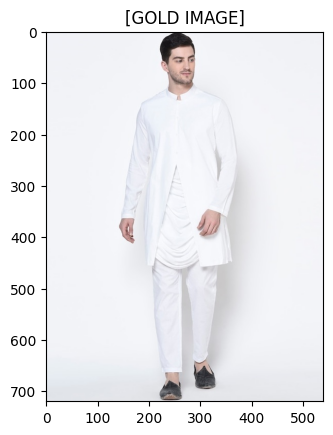

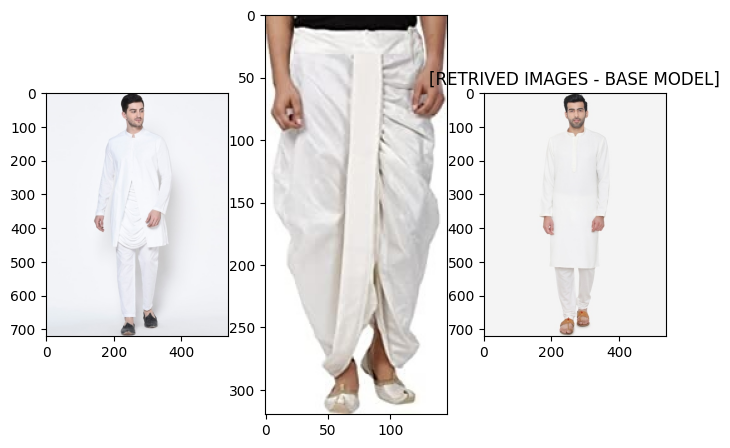

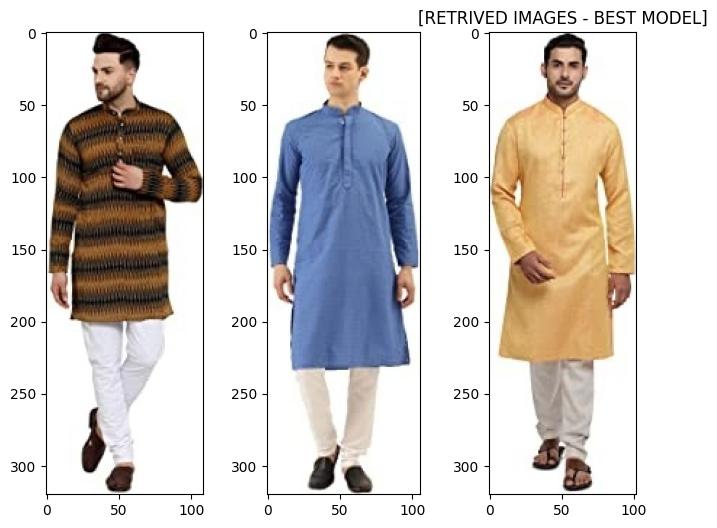

In [ ]:
index = selected_indices[0]
print("[CAPTION]")
print(base_retrieved_result["captions"][index])

# gold image
path = base_retrieved_result["GOLD_paths"][index]
images = [Image.open(path)]
plot_images(images, title="[GOLD IMAGE]")

# base
paths = base_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BASE MODEL]")

# best
paths = best_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BEST MODEL]")

[CAPTION]
Rok Kerja Potong Wanita Sari Sutra (Biru)


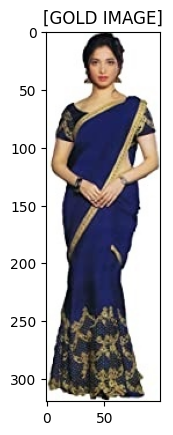

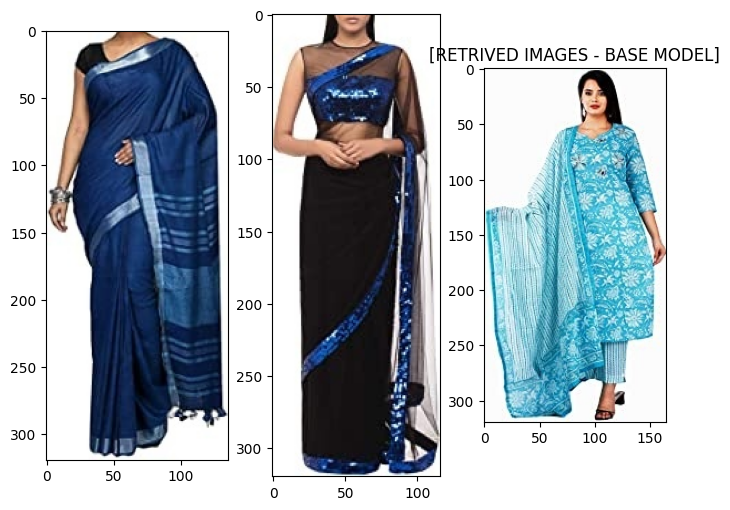

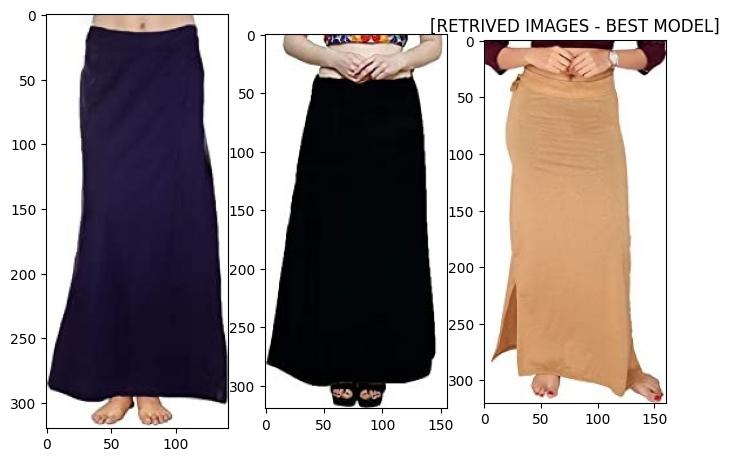

In [ ]:
index = selected_indices[1]
print("[CAPTION]")
print(base_retrieved_result["captions"][index])

# gold image
path = base_retrieved_result["GOLD_paths"][index]
images = [Image.open(path)]
plot_images(images, title="[GOLD IMAGE]")

# base
paths = base_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BASE MODEL]")

# best
paths = best_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BEST MODEL]")

[CAPTION]
Blus Sari Wanita Tanpa Lengan Beludru Kerah V Warna Siap Pakai Merah


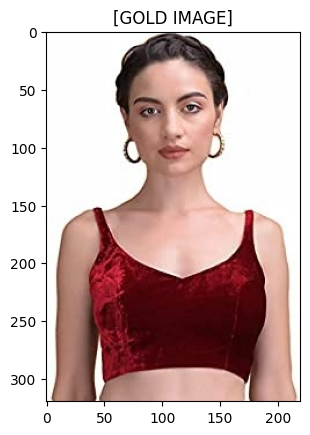

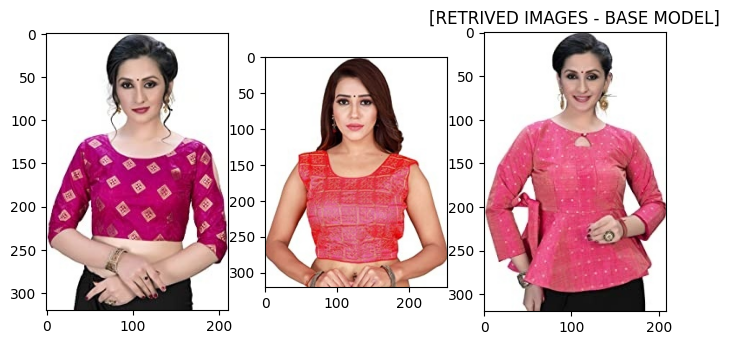

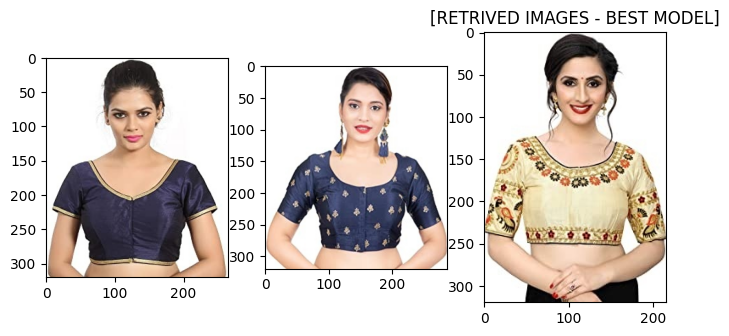

In [ ]:
index = selected_indices[2]
print("[CAPTION]")
print(base_retrieved_result["captions"][index])

# gold image
path = base_retrieved_result["GOLD_paths"][index]
images = [Image.open(path)]
plot_images(images, title="[GOLD IMAGE]")

# base
paths = base_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BASE MODEL]")

# best
paths = best_retrieved_result["top_3"][index]
images = [Image.open(path) for path in paths]
plot_images(images, title="[RETRIVED IMAGES - BEST MODEL]")

#### Internal Hits

In [ ]:
# base
for key in ["top_1", "top_3", "top_5"]:
  hit_list = []
  for idx, retrieved_paths in enumerate(base_retrieved_result[key]):
    gold_path = base_retrieved_result["GOLD_paths"][idx]
    hit = calculate_internal_hits(gold_path, retrieved_paths)
    hit_list.append(hit)

  # we use the mrr because the func is the same as mrr (calculate the mean only)
  print(f"Internal Hits {key}: {calculate_mrr(hit_list):.2%}")

Internal Hits top_1: 0.51%
Internal Hits top_3: 1.29%
Internal Hits top_5: 2.07%


In [ ]:
# best
for key in ["top_1", "top_3", "top_5"]:
  hit_list = []
  for idx, retrieved_paths in enumerate(best_retrieved_result[key]):
    gold_path = best_retrieved_result["GOLD_paths"][idx]
    hit = calculate_internal_hits(gold_path, retrieved_paths)
    hit_list.append(hit)

  # we use the mrr because the func is the same as mrr (calculate the mean only)
  print(f"Internal Hits {key}: {calculate_mrr(hit_list):.2%}")

Internal Hits top_1: 0.40%
Internal Hits top_3: 0.96%
Internal Hits top_5: 1.60%


#### Check the Label to check the similarity/association (new)

In [ ]:
# base
for key in ["top_1", "top_3", "top_5"]:
  or_list = []
  for idx, retrieved_paths in enumerate(base_retrieved_result[key]):
    gold_label = base_retrieved_result["GOLD_labels"][idx]
    retrieved_labels = []
    for retrieved_path in retrieved_paths:
      label = base_retrieved_result["GOLD_labels"][base_retrieved_result["GOLD_paths"].index(retrieved_path)]
      retrieved_labels.append(label)
    occurence_rate = calculate_occurence_rates(gold_label, retrieved_labels)
    or_list.append(occurence_rate)

  # we use the mrr because the func is the same as mrr (calculate the mean only)
  print(f"Occurence Rates {key}: {calculate_mrr(or_list):.2%}")

Occurence Rates top_1: 24.84%
Occurence Rates top_3: 25.21%
Occurence Rates top_5: 25.38%


In [ ]:
# best
for key in ["top_1", "top_3", "top_5"]:
  or_list = []
  for idx, retrieved_paths in enumerate(best_retrieved_result[key]):
    gold_label = best_retrieved_result["GOLD_labels"][idx]
    retrieved_labels = []
    for retrieved_path in retrieved_paths:
      label = best_retrieved_result["GOLD_labels"][best_retrieved_result["GOLD_paths"].index(retrieved_path)]
      retrieved_labels.append(label)
    occurence_rate = calculate_occurence_rates(gold_label, retrieved_labels)
    or_list.append(occurence_rate)

  # we use the mrr because the func is the same as mrr (calculate the mean only)
  print(f"Occurence Rates {key}: {calculate_mrr(or_list):.2%}")

Occurence Rates top_1: 62.33%
Occurence Rates top_3: 60.16%
Occurence Rates top_5: 58.79%


even though the best model retrieved images from correct label more often, but the retrieved images is not correctly retrieved.

the finetuned has the ability to select the image from the correct group of "clothes" (almost 3 times better than the base model).